G1 Project 3

Natural Language Processing Challenge

Introduction
Learning how to process text is a skill required for Data Scientists. In this project, you will put these skills into practice to identify whether a sentence was automatically translated or translated by a human.

Project Overview
In this repository you will find dataset containing sentences in Spanish and their tags: 0, if the sentences was translated by a Machine, 1, if the sentence was translated by a professional translator. Your goal is to build a classifier that is able to distinguish between the two.

Guidance
Like in a real life scenario, you are able to make your own choices and text treatment. Use the techniques you have learned and the common packages to process this data and classify the text.

Deliverables
Python Code: Provide well-documented Python code that conducts the analysis.
Accuracy estimation: Provide the teacher with your estimation of how your model will perform.
Classified Dataset: On Friday, you will receive a dataset without tags. Prepare your code to be able to tag that dataset.

Import

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

1. Read Data

In [2]:
# Read the dataset
data = pd.read_csv('training_data_lowercase.csv')  # Dataset name
print(data.head())

# Reduce the dataset size to speed up development (optional)
data = data.head(1000)  # Use a subset for faster development
print(data.shape)

# Handle missing values
data.fillna('', inplace=True)

  0\tdonald trump sends out embarrassing new year‚s eve message; this is disturbing
0  0\tdrunk bragging trump staffer started russia...                               
1  0\tsheriff david clarke becomes an internet jo...                               
2  0\ttrump is so obsessed he even has obama‚s na...                               
3  0\tpope francis just called out donald trump d...                               
4  0\tracist alabama cops brutalize black boy whi...                               
(1000, 1)


2. Dividing Training and Test Set

In [3]:
# Recargar el archivo especificando que está delimitado por tabulaciones
file_path = 'training_data_lowercase.csv'
data = pd.read_csv(file_path, delimiter='\t')

# Mostrar las primeras filas para verificar los nombres de las columnas
print(data.head())
print(data.columns)

# Renombrar las columnas para mayor claridad
data.columns = ['label', 'sentence']
                
# Verificar el contenido después de renombrar
print(data.head())

# Dividir características (X) y etiquetas (y)
X = data['sentence']  # Texto de las noticias
y = data['label']     # Etiquetas: 0 = Fake News, 1 = Real News

   0  \
0  0   
1  0   
2  0   
3  0   
4  0   

  donald trump sends out embarrassing new year‚s eve message; this is disturbing  
0  drunk bragging trump staffer started russian c...                              
1  sheriff david clarke becomes an internet joke ...                              
2  trump is so obsessed he even has obama‚s name ...                              
3  pope francis just called out donald trump duri...                              
4  racist alabama cops brutalize black boy while ...                              
Index(['0', 'donald trump sends out embarrassing new year‚s eve message; this is disturbing'], dtype='object')
   label                                           sentence
0      0  drunk bragging trump staffer started russian c...
1      0  sheriff david clarke becomes an internet joke ...
2      0  trump is so obsessed he even has obama‚s name ...
3      0  pope francis just called out donald trump duri...
4      0  racist alabama cops brutalize bl

True News

In [4]:
# Filtrar las noticias con label 1 (True/Real News)
true_news = data[data['label'] == 1]

# Mostrar las primeras 5 noticias verdaderas
print(true_news.head(5))

       label                                           sentence
17571      1  as u.s. budget fight looms\trepublicans flip t...
17572      1  u.s. military to accept transgender recruits o...
17573      1  senior u.s. republican senator: 'let mr. muell...
17574      1  fbi russia probe helped by australian diplomat...
17575      1  trump wants postal service to charge 'much mor...


3. Data Preprocessing

In [5]:
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

# Dividir características (X) y etiquetas (y)
X = data['sentence']  # Texto de las noticias
y = data['label']     # Etiquetas: 0 = Fake News, 1 = Real News

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Mostrar puntuación y palabras de ejemplo
print("Punctuation:", string.punctuation)
print("Sample Stopwords:", stopwords.words("english")[100:110])

Punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Sample Stopwords: ['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']


Lemmatization

In [6]:
import nltk
nltk.download('wordnet')  # Descargar recurso necesario
nltk.download('omw-1.4')  # Descargar datos adicionales para WordNet

# Inicializar el lematizador
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Función para limpiar texto con lemmatización
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Eliminar etiquetas HTML
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar caracteres especiales
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'\b\w\b', '', text)  # Eliminar caracteres individuales
    text = re.sub(r'\s+', ' ', text).strip()  # Reemplazar múltiples espacios por uno solo
    text = text.lower()  # Convertir a minúsculas
    # Aplicar lemmatización a cada palabra
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
# Aplicar preprocesamiento a los datos de entrenamiento y prueba
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

print("Sample Preprocessed Text:\n", X_train.head())

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kikegarciabello/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kikegarciabello/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Sample Preprocessed Text:
 1847     paul ryan make perfect argument for medicare f...
3457     evan mcmullin issue dire warning for all ameri...
23069           iraq say will stay clear of usiran tension
29487    turkey erdogan say will take jerusalem resolut...
6624     bill maher insult trump supposed masculinity a...
Name: sentence, dtype: object


Bag Of Words (*)

In [7]:
from collections import Counter

# Get top 10 words in fake and real news
fake_words = " ".join(X_train[y_train == 0]).split()
real_words = " ".join(X_train[y_train == 1]).split()

fake_top10 = Counter(fake_words).most_common(10)
real_top10 = Counter(real_words).most_common(10)

print("Top 10 Words in Fake News:", fake_top10)
print("Top 10 Words in Real News:", real_top10)

Top 10 Words in Fake News: [('trump', 5728), ('to', 5196), ('video', 4415), ('the', 3527), ('of', 2723), ('for', 2716), ('in', 2414), ('on', 2010), ('and', 1699), ('is', 1553)]
Top 10 Words in Real News: [('to', 4882), ('trump', 4142), ('u', 2840), ('in', 2603), ('on', 2149), ('say', 1958), ('of', 1779), ('for', 1711), ('house', 1151), ('with', 918)]


Extra features

In [8]:
money_symbols = "|".join(["euro", "dollar", "pound", "€", "$"])
suspicious_words = "|".join(["free", "cheap", "money", "account", "bank", "fund", "win", "password"])

data['money_mark'] = data['sentence'].str.contains(money_symbols, case=False) * 1
data['suspicious_words'] = data['sentence'].str.contains(suspicious_words, case=False) * 1
data['text_len'] = data['sentence'].apply(lambda x: len(x))

print("Sample Data with Extra Features:\n", data.head())

Sample Data with Extra Features:
    label                                           sentence  money_mark  \
0      0  drunk bragging trump staffer started russian c...           1   
1      0  sheriff david clarke becomes an internet joke ...           1   
2      0  trump is so obsessed he even has obama‚s name ...           1   
3      0  pope francis just called out donald trump duri...           1   
4      0  racist alabama cops brutalize black boy while ...           1   

   suspicious_words  text_len  
0                 0        68  
1                 0        89  
2                 0        77  
3                 0        69  
4                 0        81  


How would Bag of Words with Count Vectorizer work?

In [ ]:
'''from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

print("Count Vectorized Data Shape:", X_train_count.shape)'''

Count Vectorized Data Shape: (27320, 1000)


TF-IDF (*)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Data Shape:", X_train_tfidf.shape)

TF-IDF Data Shape: (27320, 1000)


 Train a Classifier

Naiv Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Train a Naive Bayes Classifier
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9068950373298199
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      3515
           1       0.91      0.89      0.90      3316

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831



Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_tfidf, y_train)

# Predict with Logistic Regression
y_pred_logistic = logistic_model.predict(X_test_tfidf)

# Evaluate Logistic Regression
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))


Logistic Regression:
Accuracy: 0.921241399502269
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      3515
           1       0.91      0.93      0.92      3316

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831



Random Forest

In [13]:
# Random Forest
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest_model.fit(X_train_tfidf, y_train)

# Predict with Random Forest
y_pred_rf = random_forest_model.predict(X_test_tfidf)

# Evaluate Random Forest
print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest:
Accuracy: 0.9105548235983019
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      3515
           1       0.92      0.90      0.91      3316

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831



Spanish

Resultados por modelo
Naive Bayes:
Accuracy: 90.69%. Es rápido y eficiente, pero su precisión y recall son ligeramente menores.
F1-score para ambas clases es 0.90-0.91, lo que indica un rendimiento equilibrado pero ligeramente inferior a los otros modelos.
Logistic Regression:
Accuracy: 92.12%. Es el mejor de los tres modelos en términos de precisión general.
F1-score de 0.92 para ambas clases, lo que muestra un rendimiento muy consistente y balanceado.
Random Forest:
Accuracy: 91.05%. Tiene una precisión y recall similares para ambas clases, pero ligeramente inferior al Logistic Regression.
Es más robusto que Naive Bayes, pero no supera a Logistic Regression.

Resumen simple
El mejor modelo es Logistic Regression, porque tiene la mayor precisión (92.12%) y un F1-score equilibrado para ambas clases, lo que lo hace confiable para clasificar noticias falsas y verdaderas. 😊

English

Model Results
Naive Bayes:
Accuracy: 90.69%. It's fast and simple but slightly less accurate than the others.
F1-scores are 0.90-0.91, meaning it works well but not the best.
Logistic Regression:
Accuracy: 92.12%. This is the best model in accuracy.
F1-scores are 0.92 for both classes, showing very balanced and reliable performance.
Random Forest:
Accuracy: 91.05%. It's good but not better than Logistic Regression.
F1-scores are 0.91, close to Logistic Regression but slightly lower.

Summary
Logistic Regression is the best model because it has the highest accuracy (92.12%) and performs equally well for both fake and real news. 😊

Confusiio Matrix 3 

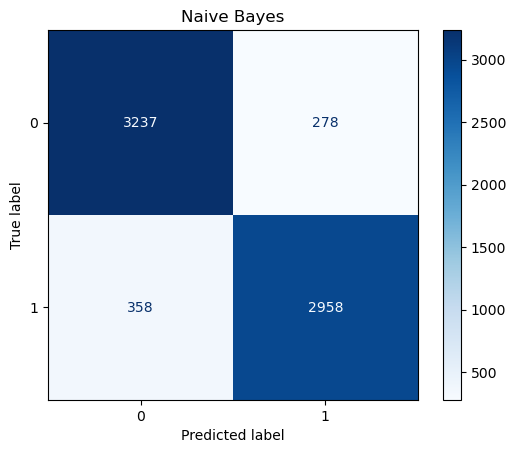

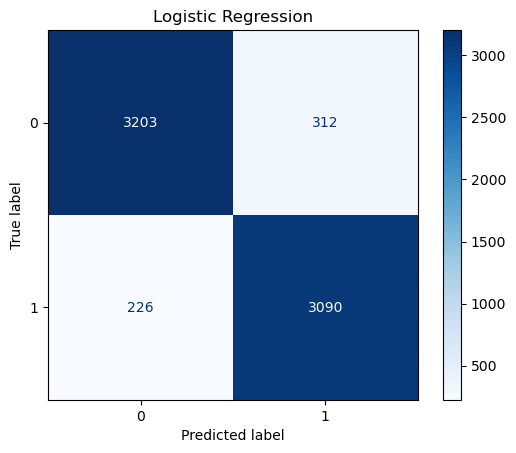

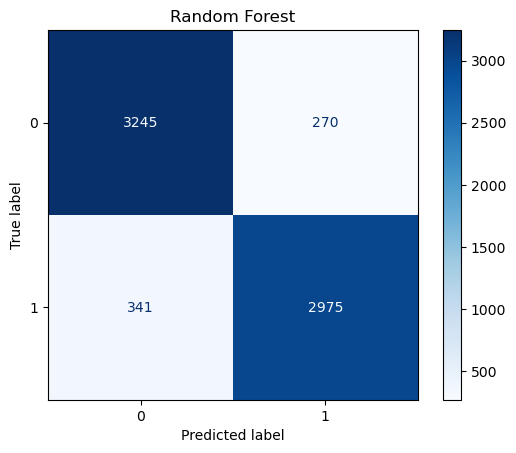

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Naive Bayes
plot_confusion_matrix(y_test, y_pred, "Naive Bayes")

# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, y_pred_logistic, "Logistic Regression")

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

Overtfitting check

In [15]:
#Overfitting verification:

# Function to check overfitting
def check_overfitting(model, X_train, y_train, X_test, y_test, name):
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print(f"{name} - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    if abs(train_acc - test_acc) > 0.05:
        print(f"Warning: {name} might be overfitting!")
    else:
        print(f"{name} shows no significant overfitting.")

# Check for Naive Bayes
check_overfitting(model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Naive Bayes")

# Check for Logistic Regression
check_overfitting(logistic_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Logistic Regression")

# Check for Random Forest
check_overfitting(random_forest_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Random Forest")

Naive Bayes - Train Accuracy: 0.9098, Test Accuracy: 0.9069
Naive Bayes shows no significant overfitting.
Logistic Regression - Train Accuracy: 0.9288, Test Accuracy: 0.9212
Logistic Regression shows no significant overfitting.
Random Forest - Train Accuracy: 0.9990, Test Accuracy: 0.9106


Verification of Model stability

why?
To check if the Logistic Regression model is stable and performs well across different splits of the training data, ensuring it generalizes to unseen data. 

In [17]:
from sklearn.model_selection import cross_val_score
import numpy as np  # Asegúrate de importar numpy

# Aplicar cross-validation en Logistic Regression
cv_scores = cross_val_score(logistic_model, X_train_tfidf, y_train, cv=5)
print(f"Logistic Regression Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

Logistic Regression Cross-Validation Accuracy: 0.9184
